In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('IMDb_dataset.csv')
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [2]:
size = 5000 # 只取部分樣本，節省運算時間

df = df.sample(n=size, random_state=0)
df.reset_index(inplace=True, drop=True)
print(df['sentiment'].value_counts())
df.head(3)

negative    2553
positive    2447
Name: sentiment, dtype: int64


,review,sentiment
0,John Cassavetes is on the run from the law. He...,positive
1,It's not just that the movie is lame. It's mor...,negative
2,"Well, if it weren't for Ethel Waters and a 7-y...",negative


In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(df['sentiment'])
df['sentiment'] = le.transform(df['sentiment'])
df.head(3)

,review,sentiment
0,John Cassavetes is on the run from the law. He...,1
1,It's not just that the movie is lame. It's mor...,0
2,"Well, if it weren't for Ethel Waters and a 7-y...",0


#### 移除或取代某些字元

In [4]:
from bs4 import BeautifulSoup
import re

def remove_noise(text):
    # 移除 HTML 標籤
    bs = BeautifulSoup(text, "html.parser")
    text = bs.get_text()
    
    # 移除中括號內的文字
    text = re.sub('\[[^]]*\]', '', text)
    
    # 將句點取代為空格
    text = text.replace('.', ' ')
    
    # 移除特殊字元、標點符號
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    
    return text

df['review'] = df['review'].apply(remove_noise)
df.loc[0, 'review']

'John Cassavetes is on the run from the law  He is at the bottom of the heap  He sees Negro Sidney Poitier as his equal and they quickly become friends forming a sort of alliance against a bully of a foreman played by Jack Warden As someone who has worked in a warehouse myself when I was younger I can tell you that the warehouse fights complete with tumbling packing cases and flailing grappling hooks are as realistic as it gets  Ive been in fights like these myself although no one got killed The introduction of Sidney Poitiers widow is a variation on Shakespeares Shylock Do I not bleed This is an anti racist film which at the time was much needed All the three principle characters  Warden Cassavetes and Poitier  are superb with Warden the most outstanding of the three '

#### 提取詞幹

In [5]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

# 提取詞幹
def get_stemming(text):
    text = ' '.join([porter.stem(w) for w in text.split()])   
    return text

df['review'] = df['review'].apply(get_stemming)
df.loc[0, 'review']

'john cassavet is on the run from the law He is at the bottom of the heap He see negro sidney poitier as hi equal and they quickli becom friend form a sort of allianc against a bulli of a foreman play by jack warden As someon who ha work in a warehous myself when I wa younger I can tell you that the warehous fight complet with tumbl pack case and flail grappl hook are as realist as it get ive been in fight like these myself although no one got kill the introduct of sidney poitier widow is a variat on shakespear shylock Do I not bleed thi is an anti racist film which at the time wa much need all the three principl charact warden cassavet and poitier are superb with warden the most outstand of the three'

#### 切割訓練集、測試集

In [6]:
train_size = 0.8

X_train = df.loc[:size*train_size-1, 'review'].values
y_train = df.loc[:size*train_size-1, 'sentiment'].values
X_test = df.loc[size*train_size:, 'review'].values
y_test = df.loc[size*train_size:, 'sentiment'].values

dct = {'總筆數': [X_train.shape[0], X_test.shape[0]], 
       '正評論筆數': [y_train.sum(), y_test.sum()], 
       '負評論筆數': [(y_train==0).sum(), (y_test==0).sum()]}
pd.DataFrame(dct, index=['訓練集', '測試集'])

,總筆數,正評論筆數,負評論筆數
訓練集,4000,1954,2046
測試集,1000,493,507


#### 詞袋模型向量化

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer()
X_train_cvec = count_vec.fit_transform(X_train)
X_test_cvec = count_vec.transform(X_test)

print('訓練集(BoW)：', X_train_cvec.shape)
print('測試集(BoW)：', X_test_cvec.shape)

訓練集(BoW)： (4000, 29963)
測試集(BoW)： (1000, 29963)


#### TF-IDF 向量化

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

print('訓練集(tf-idf)：', X_train_tfidf.shape)
print('測試集(tf-idf)：', X_test_tfidf.shape)

訓練集(tf-idf)： (4000, 29963)
測試集(tf-idf)： (1000, 29963)


#### TF-IDF + 機器學習模型 + 網格搜尋

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('vec', count_vec), 
                 ('clf', LogisticRegression())])

param_grid = [{'vec': [CountVectorizer()],
               'vec__stop_words': ['english', None],
               'clf': [LogisticRegression(n_jobs=-1)],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': np.logspace(-2, 2, 10)}, 
              {'vec': [TfidfVectorizer()],
               'vec__stop_words': ['english', None],
               'vec__norm':['l1', 'l2', None],
               'clf': [LogisticRegression(n_jobs=-1)],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': np.logspace(-2, 2, 10)},
              {'vec': [CountVectorizer()],
               'vec__stop_words': ['english', None],
               'clf': [MultinomialNB()]},
              {'vec': [TfidfVectorizer()],
               'vec__stop_words': ['english', None],
               'vec__norm':['l1', 'l2', None],
               'clf': [MultinomialNB()]},
              ]

gs = GridSearchCV(pipe, param_grid, scoring='accuracy', 
                  cv=5, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prepr

#### 搜尋到的最佳參數組合

In [10]:
print('Best parameters:', gs.best_params_)

Best parameters: {'clf': LogisticRegression(C=4.6415888336127775, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'clf__C': 4.6415888336127775, 'clf__penalty': 'l2', 'vec': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), 'vec__norm': 'l2', 'vec__stop_words': None}


#### 分類準確率

In [11]:
print('Train accuracy:', gs.best_score_)
clf = gs.best_estimator_
print('Test accuracy:', clf.score(X_test, y_test))

Train accuracy: 0.85
Test accuracy: 0.875


In [12]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
clf_report = classification_report(y_test, y_pred, target_names=le.classes_)
print(clf_report)

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87       507
    positive       0.86      0.89      0.88       493

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000



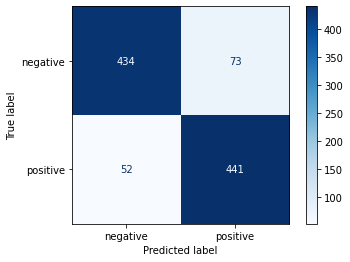

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, 
                      display_labels=le.classes_,
                      values_format = 'd',
                      cmap=plt.cm.Blues);

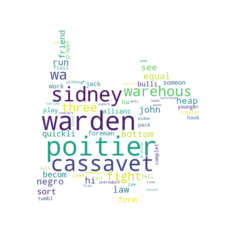

In [14]:
# 要先安裝 wordcloud 套件
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

# 文字雲造型圖片
mask = np.array(Image.open('pikachu.jpg'))

wc = WordCloud(
  background_color='white', #   背景顏色
  max_words=200,            #   最大分詞數量
  mask=mask,                #   背景圖片
  min_font_size=5)          #   顯示字體的最小值

# 生成文字雲
wc.generate(X_train[0])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');